<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-Diego1733/blob/main/ProyectoML/ProyectoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Función de onda:
Los datos son valores de amplitud de presión en una onda sonoraen función del tiempo

### Parametros a estimar:

A: Amplitud

La amplitud (A) representa la máxima distancia desde la línea central de la onda sinusoidal hasta su punto máximo o mínimo. En otras palabras, controla cuán "alto" o "bajo" es el pico de la onda.
omega (ω): Frecuencia angular

La frecuencia angular (omega o ω) determina la rapidez con la que la onda oscila y se repite a lo largo del tiempo. Cuanto mayor sea el valor de ω, más rápida será la oscilación de la onda.
phi (φ): Fase

La fase (phi o φ) indica el desplazamiento horizontal de la onda en relación con un punto de referencia. Determina en qué punto de su ciclo la onda comienza en el tiempo.
offset: Desplazamiento vertical

El offset es un término que agrega una constante a la ecuación de la onda, lo que significa que desplaza verticalmente la onda. Esto puede considerarse como un cambio en el valor medio de la onda.

In [3]:
!pip install emcee
!pip install corner

  Using cached emcee-3.1.4-py2.py3-none-any.whl (46 kB)


In [82]:
import matplotlib.pyplot as plt
import emcee
import numpy as np
import corner

In [89]:
# DATOS REALES:

A_true = 2.0
omega_true = 1.0
phi_true = np.pi / 4
offset_true = 0.5
noise_stddev = 1.0  # Mayor desviación estándar del ruido

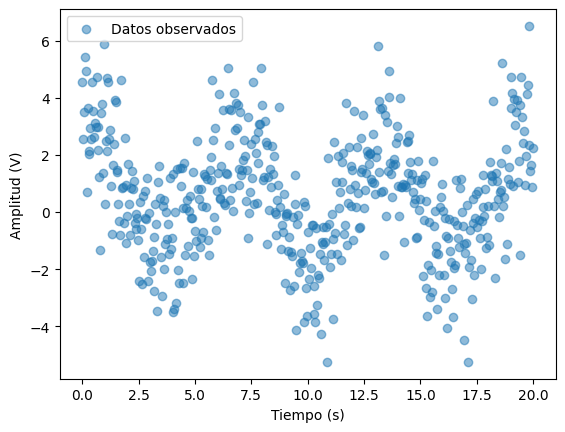

In [97]:
# Cargar datos

data = np.loadtxt('/content/drive/MyDrive/ML2023/onda_sonora.txt')
t_observed, y_observed = data[:, 0], data[:, 1]

# Visualizar datos observados
plt.figure()
plt.scatter(t_observed, y_observed, label='Datos observados', alpha=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (V)')
plt.legend()
plt.show()

Se observa que toma forma senoidal, además que tenía conocimiento previo de que eran datos de una onda, por lo tanto busqué un modelo en internet para la función de onda que cumpliera con los requerimientos del proyecto.

$$ y(t)= A sin (ωt+ϕ) + offset$$


*   y(t) es la amplitud de la onda en un momento
*   A es la amplitud de la onda, que determina la altura máxima de la onda.
*   ω (omega) es la frecuencia angular de la onda, que controla la rapidez de oscilación.
*   ϕ (phi) es la fase de la onda, que determina la posición inicial de la onda en su ciclo.
*   offset es el desplazamiento vertical, que ajusta el valor medio de la onda.

In [95]:
# Define la ecuación del modelo
def onda_model(t, A, omega, phi, offset):
    return A * np.sin(omega * t + phi) + offset

# Define el logaritmo del likelihood
def ln_likelihood(params, t, y, noise_stddev):
    A, omega, phi, offset = params
    y_pred = onda_model(t, A, omega, phi, offset)
    return -0.5 * np.sum((y - y_pred) ** 2 / noise_stddev ** 2)

# Define el logaritmo del prior
def ln_prior(params):
    A, omega, phi, offset = params
    if 0 < A < 10 and 0 < omega < 10 and 0 <= phi < 2 * np.pi and -1 < offset < 1:
        return 0.0
    return -np.inf

# Define el logaritmo de la probabilidad posterior
def ln_posterior(params, t, y, noise_stddev):
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, t, y, noise_stddev)

100%|██████████| 1000/1000 [00:04<00:00, 230.51it/s]


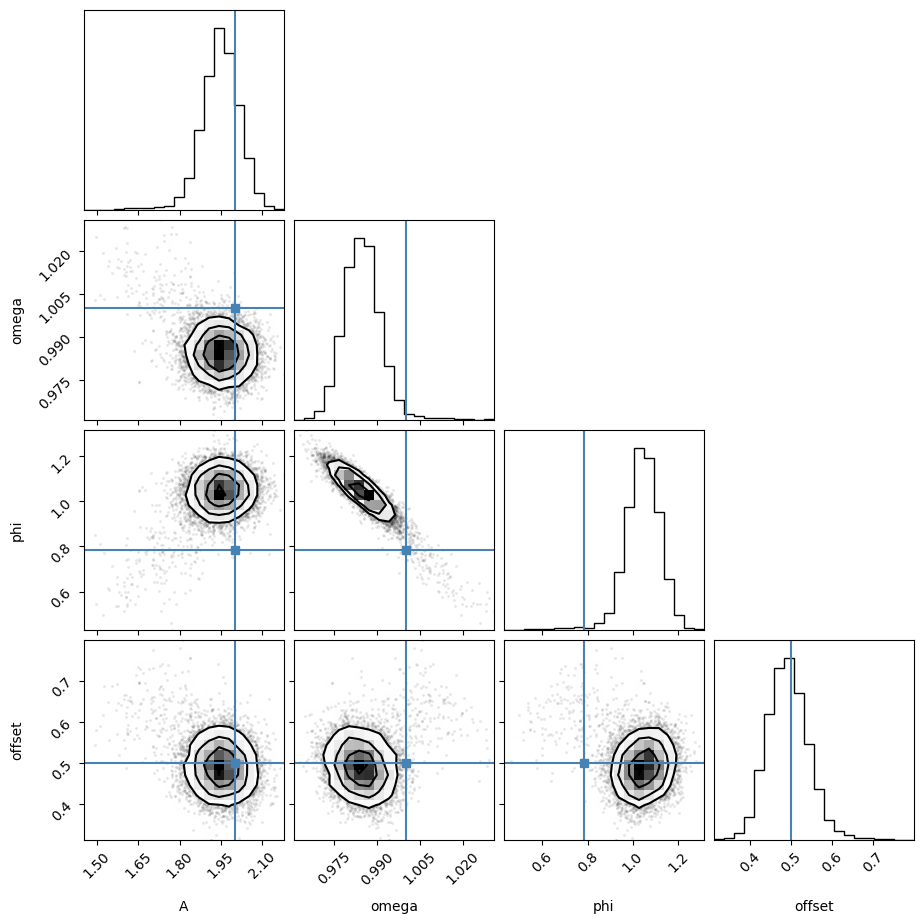

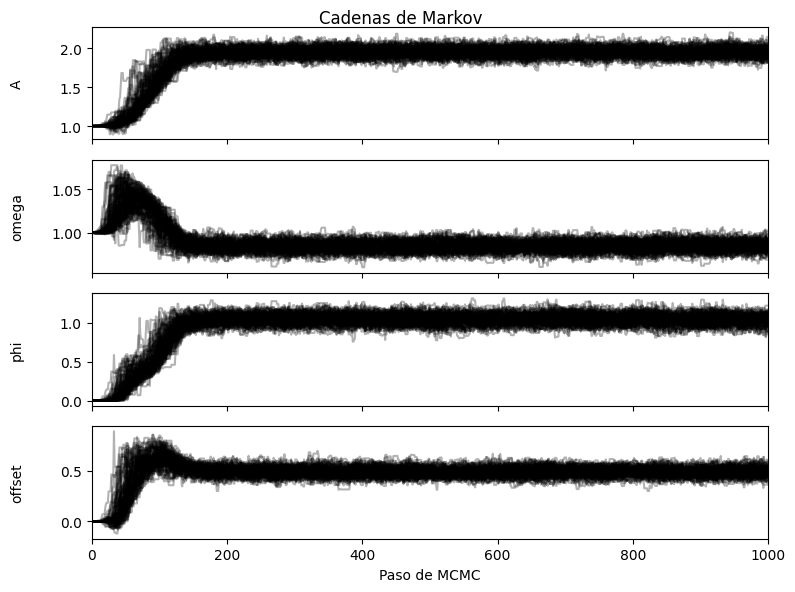

In [100]:
# Configuración de MCMC
nwalkers = 100
ndim = 4
nsteps = 1000

# amplitud (A), frecuencia angular (omega), fase (phi) y desplazamiento vertical (offset).
initial_guess = [1.0, 1.0, 0.0, 0.0]

# Inicializa los caminantes de MCMC
initial_positions = [initial_guess + 1e-4*np.random.randn(ndim) for _ in range(nwalkers)]

# Configura el Sampler de emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(t_observed, y_observed, noise_stddev))

# Ejecuta el MCMC
sampler.run_mcmc(initial_positions, nsteps, progress=True)

# Visualiza los resultados con corner
samples = sampler.get_chain(discard=100, thin=10, flat=True)
labels = ["A", "omega", "phi", "offset"]

# Visualiza los datos reales
fig = corner.corner(samples, labels=labels, truths=[A_true, omega_true, phi_true, offset_true])

# Carga las muestras de las cadenas de Markov
samples = sampler.get_chain()

# Nombres de los parámetros
param_names = ["A", "omega", "phi", "offset"]

# Configura subtramas para cada parámetro
fig, axes = plt.subplots(len(param_names), figsize=(8, 6), sharex=True)
fig.suptitle("Cadenas de Markov")

# Grafica cada cadena de Markov
for i in range(len(param_names)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Etiqueta el eje x en la parte inferior
axes[-1].set_xlabel("Paso de MCMC")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

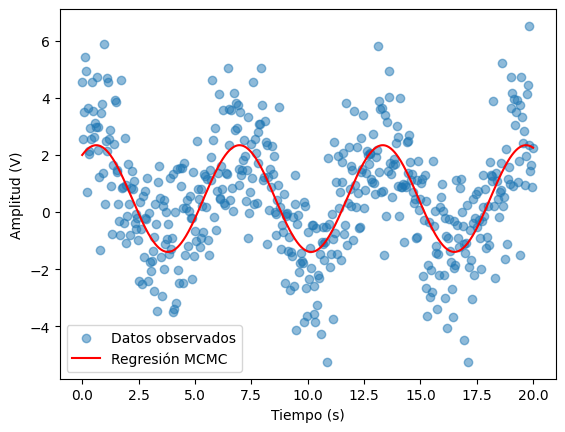

In [107]:
# Promedio de las muestras para obtener los valores estimados de los parámetros
estimated_params = np.mean(samples, axis=(0, 1))

# Parámetros estimados
A_est, omega_est, phi_est, offset_est = estimated_params

# Crea un conjunto de puntos de tiempo para la regresión
t_regression = np.linspace(t_observed.min(), t_observed.max(), 1000)

# Calcula los valores estimados de la regresión
y_regression = onda_model(t_regression, A_est, omega_est, phi_est, offset_est)

# Grafica los datos observados y la regresión
plt.figure()
plt.scatter(t_observed, y_observed, label='Datos observados', alpha=0.5)
plt.plot(t_regression, y_regression, color='red', label='Regresión MCMC')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (V)')
plt.legend()
plt.show()